# 3er intento de Examen 1 curso Machine Learning (MITIC-DS-A-Septiembre-2024) : «Customer Churn Dataset.

# Churn: Variable objetivo (1: Si Churn, 0: no Churn)

## **Configuración**

In [86]:
import pandas as pd
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import plotly.express as px
from IPython.display import HTML, Image
import utils_profe
from collections import Counter
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency
from tabulate import tabulate

import scipy.stats as stats
# Importar las bibliotecas necesarias
from xgboost import XGBClassifier  # Modelo XGBoost
from sklearn.model_selection import RandomizedSearchCV  # Para optimizar los hiperparámetros
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc  # Para evaluar el rendimiento del modelo

from utils_profe import *
path = '../../data/customer_churn_dataset-training-master.csv'
df = pd.read_csv(filepath_or_buffer=path, sep= ',', header=0)
print(df.shape)
df.info()

(440833, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [2]:
#Tasa de falsos positivo es fpr, Tasa de Verdadeos positivos es tpr
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1],[0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [3]:
def ver_diccionario(diccionario_file):
    # Carga del diccionario de datos desde el archivo CSV
    # Asegúrate de reemplazar 'diccionario.csv' por el nombre de tu archivo
    diccionario = pd.read_csv(f'../../data/{diccionario_file}')

    # Mostrar los datos tabulados con `tabulate`
    tabla = tabulate(diccionario, headers='keys', tablefmt='fancy_grid', showindex=False)

    # Imprimir la tabla
    print(tabla)

def ver_distro(df,columna,leyenda):
    # Calcular los parámetros de la distribución normal (media y desviación estándar)
    media = df[columna].mean()
    desviacion_estandar = df[columna].std()

    # Definir el rango de valores para la campana
    x = np.linspace(df[columna].min(), df[columna].max(), 100)

    # Generar la curva de la distribución normal
    y = stats.norm.pdf(x, media, desviacion_estandar)

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(8, 4))

    # Histograma de la columna 'Glucose'
    df[columna].plot(kind='hist', bins=50, color='lightgreen', edgecolor='black', ax=ax, density=True)

    # Añadir la campana de Gauss
    ax.plot(x, y, color='red', label='Distribución Normal')

    # Título y etiquetas
    ax.set_title(f"Distribución de {leyenda}", fontsize=14)
    ax.set_xlabel(leyenda, fontsize=12)
    ax.set_ylabel("Frecuencia", fontsize=12)

    # Añadir leyenda
    ax.legend()

    # Ajustar y mostrar el gráfico
    plt.tight_layout()
    plt.show()    

In [4]:
ver_diccionario('diccionario_telco.csv')

╒═════╤═══════════════════╤═════════╤══════════════════════════════════════════════════════════════════════════╤═══════════╕
│   # │ Columna           │ Tipo    │ Descripción                                                              │ Ejemplo   │
╞═════╪═══════════════════╪═════════╪══════════════════════════════════════════════════════════════════════════╪═══════════╡
│   1 │ CustomerID        │ float64 │ Identificador único del cliente                                          │ 101.0     │
├─────┼───────────────────┼─────────┼──────────────────────────────────────────────────────────────────────────┼───────────┤
│   2 │ Age               │ float64 │ Edad del cliente en años                                                 │ 35.0      │
├─────┼───────────────────┼─────────┼──────────────────────────────────────────────────────────────────────────┼───────────┤
│   3 │ Gender            │ object  │ Género del cliente (Masculino, Femenino)                                 │ Masculino │


In [5]:
# Crear el DataFrame con los datos
data_diccionario = {
    "Columna": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Nombre": [
        "CustomerID", "Age", "Gender", "Tenure", "Usage Frequency",
        "Support Calls", "Payment Delay", "Subscription Type", 
        "Contract Length", "Total Spend", "Last Interaction", "Churn"
    ],
    "Tipo": [
        "float64", "float64", "object", "float64", "float64",
        "float64", "float64", "object", 
        "object", "float64", "float64", "float64"
    ],
    "Descripción": [
        "Identificador único del cliente",
        "Edad del cliente en años",
        "Género del cliente (Masculino, Femenino)",
        "Antigüedad del cliente en meses",
        "Frecuencia de uso del servicio (veces por período definido)",
        "Número de llamadas realizadas al soporte técnico",
        "Retrasos en pagos (en días)",
        "Tipo de suscripción contratada (por ejemplo, Básica, Premium)",
        "Duración del contrato (por ejemplo, Mensual, Anual)",
        "Gasto total realizado por el cliente (en la moneda local)",
        "Tiempo (en días) desde la última interacción del cliente con el servicio",
        "Indicador de abandono (1 si el cliente abandonó, 0 si permaneció)"
    ],
    "Ejemplo": [
        101.0, 35.0, "Masculino", 24.0, 15.0,
        2.0, 5.0, "Premium", 
        "Anual", 500.50, 30.0, 1.0
    ]
}

df_diccionario = pd.DataFrame(data_diccionario)

# Función para obtener la descripción a partir del nombre de la columna
def obtener_descripcion_por_nombre(nombre_columna):
    fila = df_diccionario[df_diccionario["Nombre"] == nombre_columna]
    if not fila.empty:
        return fila.iloc[0]["Descripción"]
    else:
        return "El nombre de la columna no existe en el DataFrame."

## Limpieza de datos con Python:

### **Verificación y ajuste de tipos de datos** 

Asegúrate de que todas las columnas coincidan con los tipos de datos indicados en el diccionario de datos.

In [6]:
df.head().T

,0,1,2,3,4
CustomerID,2.0,3.0,4.0,5.0,6.0
Age,30.0,65.0,55.0,58.0,23.0
Gender,Female,Female,Female,Male,Male
Tenure,39.0,49.0,14.0,38.0,32.0
Usage Frequency,14.0,1.0,4.0,21.0,20.0
Support Calls,5.0,10.0,6.0,7.0,5.0
Payment Delay,18.0,8.0,18.0,7.0,8.0
Subscription Type,Standard,Basic,Basic,Standard,Basic
Contract Length,Annual,Monthly,Quarterly,Monthly,Monthly
Total Spend,932.0,557.0,185.0,396.0,617.0


Realizamos un respaldo del df original

In [7]:
df_original = df.copy()

In [8]:
#Eliminamos CustomerID
df.drop(['CustomerID'], axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage Frequency    440832 non-null  float64
 4   Support Calls      440832 non-null  float64
 5   Payment Delay      440832 non-null  float64
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 37.0+ MB


In [10]:
#Ver si hay valores nulos
df.isnull().sum()

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [11]:
#Eliminamos, es solo 1
df.dropna(inplace=True)

In [12]:
df.isnull().sum()

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage Frequency    440832 non-null  float64
 4   Support Calls      440832 non-null  float64
 5   Payment Delay      440832 non-null  float64
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 40.4+ MB


YA No hay mas nulos, tenemos datos en todas las columnas.

In [14]:
# Detectar columnas con valores únicos ['Yes', 'No']
yes_no_columns = [col for col in df.columns if sorted(df[col].dropna().unique()) == ['No', 'Yes']]
print("Columnas con valores 'Yes' y 'No':", yes_no_columns)
# Aplicar el mapeo 'Yes' -> 1 y 'No' -> 0 a todas las columnas de una vez usando map y itertools
df[yes_no_columns] = pd.DataFrame(
    map(lambda col: df[col].map({'Yes': 1, 'No': 0}), yes_no_columns)
).T.set_axis(yes_no_columns, axis=1)

Columnas con valores 'Yes' y 'No': []


In [15]:
utils_profe.generar_diccionario(df)

data_dict = {
    'Age': 'float64',
    'Gender': 'object',
    'Tenure': 'float64',
    'Usage Frequency': 'float64',
    'Support Calls': 'float64',
    'Payment Delay': 'float64',
    'Subscription Type': 'object',
    'Contract Length': 'object',
    'Total Spend': 'float64',
    'Last Interaction': 'float64',
    'Churn': 'float64',
}


In [16]:

data_dict = {
    'Age': 'float64',
    'Gender': 'object',
    'Tenure': 'float64',
    'Usage Frequency': 'float64',
    'Support Calls': 'float64',
    'Payment Delay': 'float64',
    'Subscription Type': 'category',
    'Contract Length': 'category',
    'Total Spend': 'float64',
    'Last Interaction': 'float64',
    'Churn': 'float64'
}
# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    df[column] = df[column].astype(dtype, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Age                440832 non-null  float64 
 1   Gender             440832 non-null  object  
 2   Tenure             440832 non-null  float64 
 3   Usage Frequency    440832 non-null  float64 
 4   Support Calls      440832 non-null  float64 
 5   Payment Delay      440832 non-null  float64 
 6   Subscription Type  440832 non-null  category
 7   Contract Length    440832 non-null  category
 8   Total Spend        440832 non-null  float64 
 9   Last Interaction   440832 non-null  float64 
 10  Churn              440832 non-null  float64 
dtypes: category(2), float64(8), object(1)
memory usage: 34.5+ MB


La conversión fue exitosa

### **Detección y eliminación de valores duplicados** 

Asegúrate de que cada registro en el dataset sea único

In [17]:
# Identificar duplicados
duplicados = df[df.duplicated(keep=False)]

# Mostrar los duplicados encontrados
if not duplicados.empty:
    print("Duplicados eliminados:")
    print(duplicados)
else:
    print("No se encontraron duplicados para eliminar.")

# Eliminar duplicados
df = df.drop_duplicates()

No se encontraron duplicados para eliminar.


### **Consistencia en valores categóricos**

Identifica y corrige cualquier inconsistencia en los valores categóricos (por ejemplo, ‘Junior’, ‘junior’, ‘JUNIOR’)

In [18]:
# Identificar columnas de tipo 'object', típicamente usadas para variables categóricas
categorical_columns = df.select_dtypes(include=['category','bool']).columns
# Crear un diccionario donde cada clave es el nombre de la columna y los valores son los valores únicos de esa columna
unique_values_dict = {col: df[col].unique() for col in categorical_columns}
# Convertir el diccionario en un DataFrame, rellenando con NaN cuando haya menos valores únicos
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index').transpose()
# Mostrar el DataFrame resultante
unique_values_df.T

,0,1,2
Subscription Type,Standard,Basic,Premium
Contract Length,Annual,Monthly,Quarterly


Los categoricos son correctos 

### **Manejo de valores faltantes:**

Identifica y maneja cualquier valor faltante en el dataset. Rellena los valores faltantes con un marcador adecuado para el tipo de dato

In [19]:
utils_profe.calculate_na_statistics(df)

,datos sin NAs en q,Na en q,Na en %
Age,440832,0,0.0
Gender,440832,0,0.0
Tenure,440832,0,0.0
Usage Frequency,440832,0,0.0
Support Calls,440832,0,0.0
Payment Delay,440832,0,0.0
Subscription Type,440832,0,0.0
Contract Length,440832,0,0.0
Total Spend,440832,0,0.0
Last Interaction,440832,0,0.0


Asegurar que no hay datos faltantes.

# NO HAY DATOS FALTANTES

### **Detección de datos anómalos:**

Identifica y corrige cualquier punto de dato inapropiado o inusual (por ejemplo, un salario anual de 1 millón de dólares para un puesto de entrada).

In [20]:
# Identify numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = utils_profe.detect_outliers_iqr(df[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': df[column][~outliers].min(),
        'Upper Bound': df[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
Age,0.0,0.0,18.0,65.0
Tenure,0.0,0.0,1.0,60.0
Usage Frequency,0.0,0.0,1.0,30.0
Support Calls,0.0,0.0,0.0,10.0
Payment Delay,0.0,0.0,0.0,30.0
Total Spend,0.0,0.0,100.0,1000.0
Last Interaction,0.0,0.0,1.0,30.0
Churn,0.0,0.0,0.0,1.0


In [21]:
ver_diccionario('diccionario_telco.csv')

╒═════╤═══════════════════╤═════════╤══════════════════════════════════════════════════════════════════════════╤═══════════╕
│   # │ Columna           │ Tipo    │ Descripción                                                              │ Ejemplo   │
╞═════╪═══════════════════╪═════════╪══════════════════════════════════════════════════════════════════════════╪═══════════╡
│   1 │ CustomerID        │ float64 │ Identificador único del cliente                                          │ 101.0     │
├─────┼───────────────────┼─────────┼──────────────────────────────────────────────────────────────────────────┼───────────┤
│   2 │ Age               │ float64 │ Edad del cliente en años                                                 │ 35.0      │
├─────┼───────────────────┼─────────┼──────────────────────────────────────────────────────────────────────────┼───────────┤
│   3 │ Gender            │ object  │ Género del cliente (Masculino, Femenino)                                 │ Masculino │


<a id='sec_3'></a>
## `2. Exploración de datos`

El objetivo de esta fase es poder familiarizarnos con la información contenida mediante visualizaciones univariadas y multivariadas, de la misma forma un analisis descriptivo.

1. Visualizaciones univariadas
2. Visualizaciones multivariadas.
3. Estadísticas descriptivas.

In [22]:
# Vemos la distrobucion de las variables numericas
desc(df[numerical_columns])

,count,mean,std,min,25%,50%,75%,max,%std/mean
Age,440832.0,39.373153,12.442369,18.0,29.0,39.0,48.0,65.0,31.60
Tenure,440832.0,31.256336,17.255727,1.0,16.0,32.0,46.0,60.0,55.21
Usage Frequency,440832.0,15.807494,8.586242,1.0,9.0,16.0,23.0,30.0,54.32
Support Calls,440832.0,3.604437,3.070218,0.0,1.0,3.0,6.0,10.0,85.18
Payment Delay,440832.0,12.965722,8.258063,0.0,6.0,12.0,19.0,30.0,63.69
Total Spend,440832.0,631.616223,240.803001,100.0,480.0,661.0,830.0,1000.0,38.12
Last Interaction,440832.0,14.480868,8.596208,1.0,7.0,14.0,22.0,30.0,59.36
Churn,440832.0,0.567107,0.495477,0.0,0.0,1.0,1.0,1.0,87.37


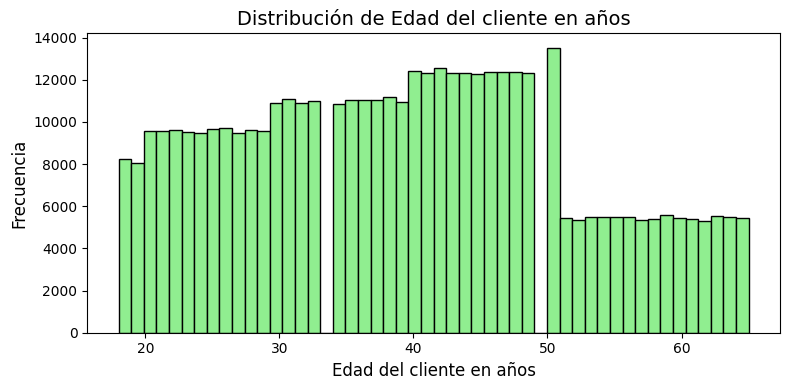

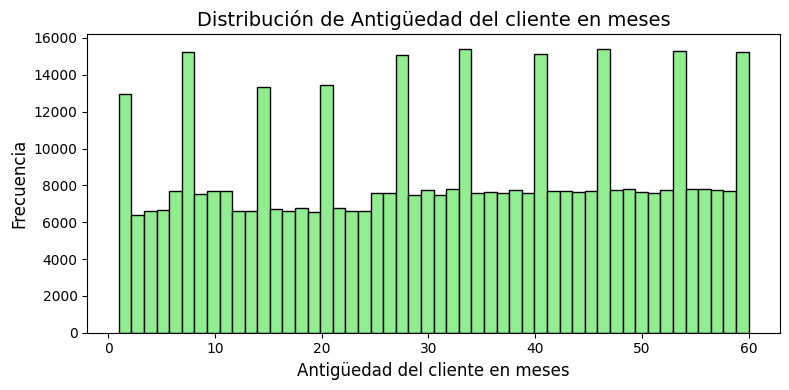

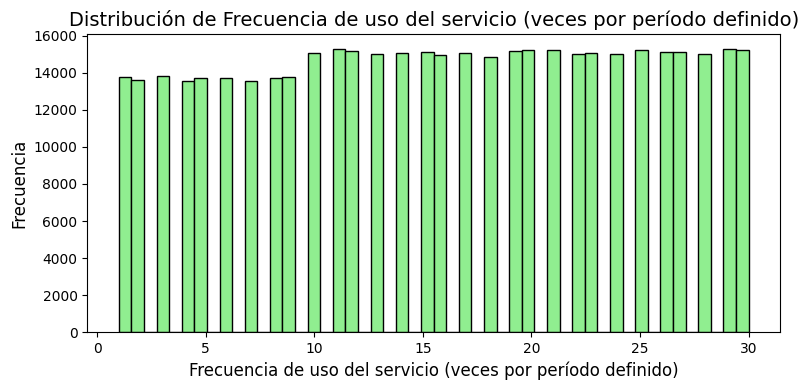

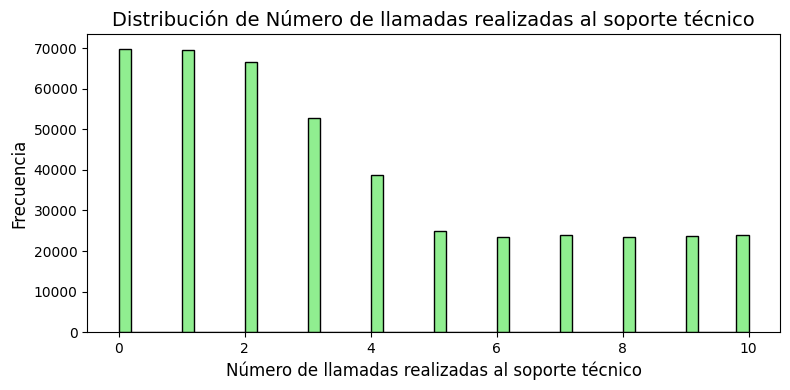

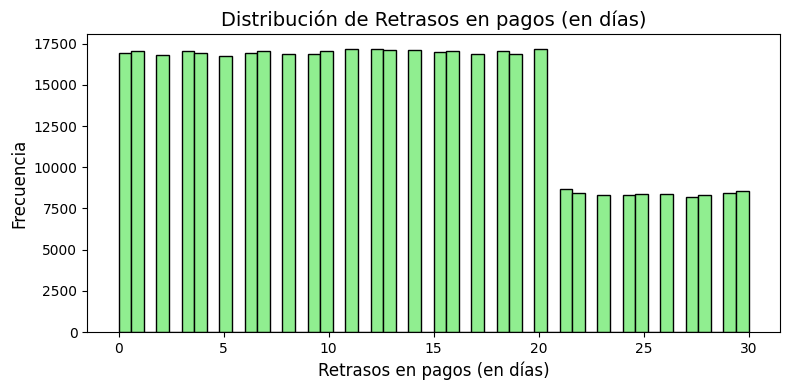

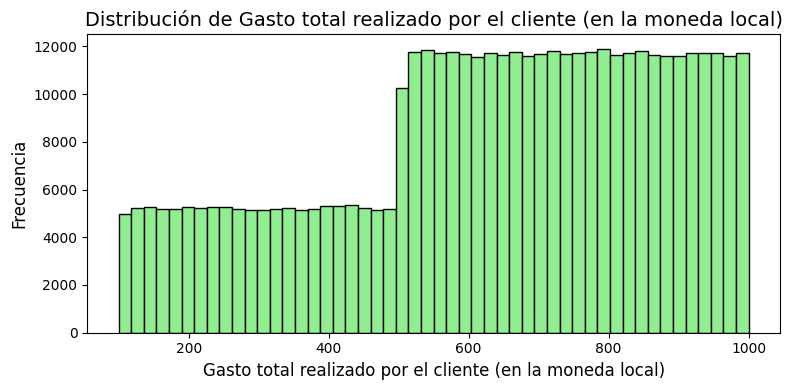

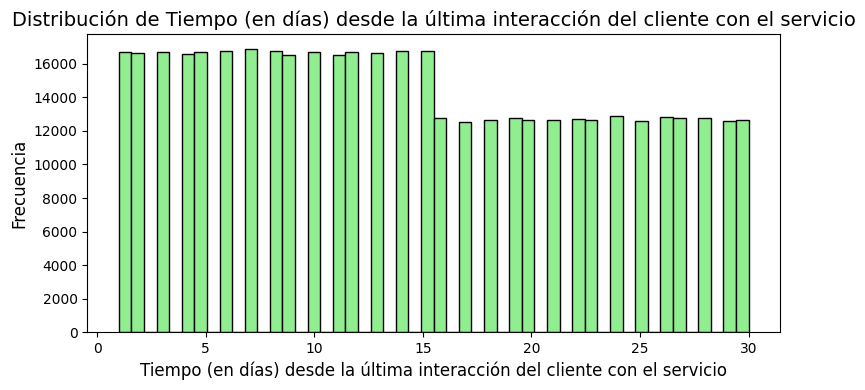

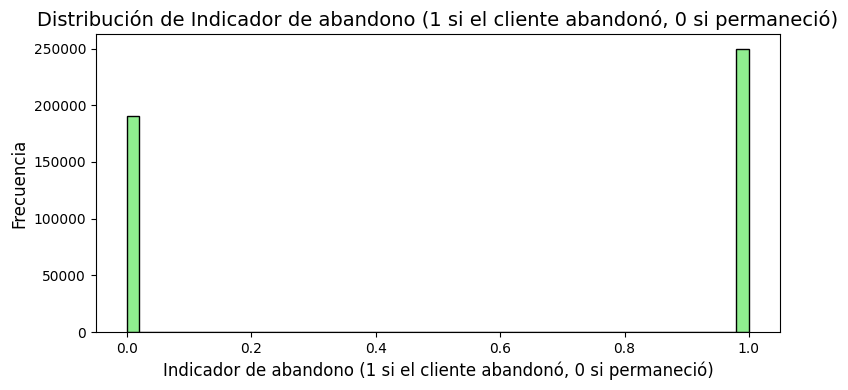

In [23]:
# Crear un histograma para cada columna numérica
for i, column in enumerate(numerical_columns, 1):
    leyenda = obtener_descripcion_por_nombre(column)
    columna = column
    fig, ax = plt.subplots(figsize=(8, 4))
    df[columna].plot(kind='hist', bins=50, color='lightgreen', edgecolor='black', ax=ax)
    ax.set_title(f"Distribución de {leyenda}", fontsize=14)
    ax.set_xlabel(leyenda, fontsize=12)
    ax.set_ylabel("Frecuencia", fontsize=12)
    plt.tight_layout()
    plt.show()

# Observaciones sobre los hist
- Ninguno de los hist tiene una ditro normal.
- La edad de los clientes van de 18 a 65 años. 
- Se tienen muchos clientes antiguos.
- Hay casi 70mil clientes que no han llamado al soporte. Veo que a partir de la tercera llamada al soporte hay una posible relación con los clientes que han salido. Son 50mil.
- El costo minimo mensual es de 100 dolares. El maximo mil dolares.
- Con respecto al uso diario, hay clientes que pasan 1 día sin usar el servicio.
- Con respecto a la mora, pocos son los clientes que están al día.



In [24]:
# Calcular la cantidad de clientes que han abandonado
clientes_abandonaron = df[df["Churn"] == 1].shape[0]

print(f"Cantidad de clientes que han abandonado: {clientes_abandonaron}")


Cantidad de clientes que han abandonado: 249999


#### Visualización 2

**Hipótesis planteada**

* Hay una oportunidad para generar contratos que pasen del cargo mes al trimestral, para asegurar la fidelidad. Aparentemente a los clientes no les gusta los contratos anuales pero se podría plantear el trimestral.

* Es posible llegar a más ciudadanos de edad avanzada "senior citizens"(¿? No salio el grafico)

* Es probable que sea o el costo o la duración del contrato?

* El costo de gasto o inversión no pasa por la edad. 

**Análisis descriptivo que lo sustenta**

* La mayoria de los que se quedan tienen contratos trimestrales.
* La mayoría de los que se van tienen mensuales.
* Hay clientes que salen sin una llamada de soporte.
* Hay clientes que gastan igual cantidad de dinero de todas las edades.

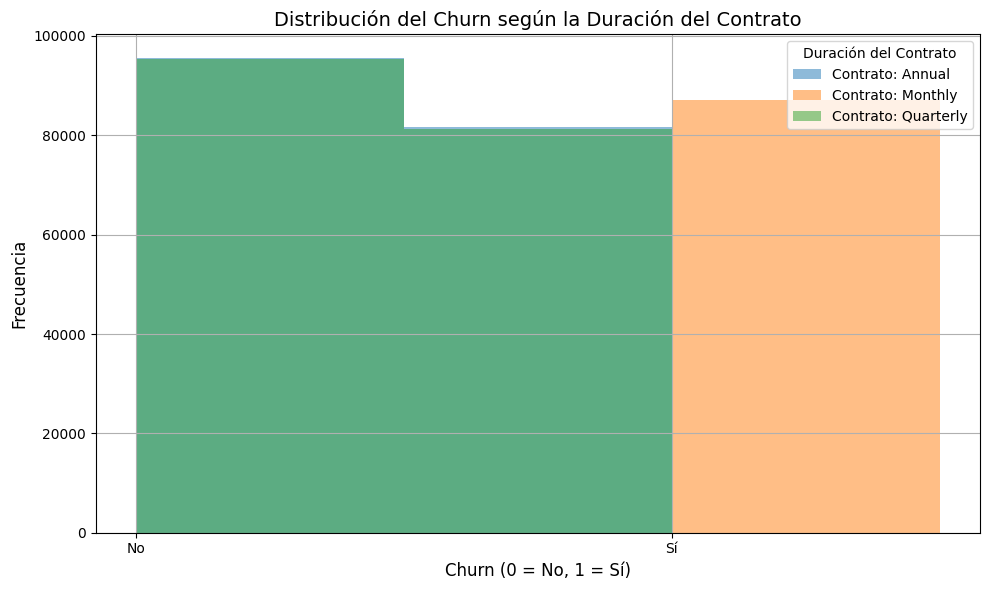

In [25]:
# Crear un histograma para visualizar el churn según la duración del contrato
plt.figure(figsize=(10, 6))

# Agrupar por 'Contract Length' y calcular la distribución de 'Churn' en cada grupo
for contract_length in df['Contract Length'].unique():
    subset = df[df['Contract Length'] == contract_length]
    
    # Graficar el histograma de Churn para cada tipo de contrato
    plt.hist(subset['Churn'], bins=2, alpha=0.5, label=f'Contrato: {contract_length}')

# Añadir detalles de la gráfica
plt.title("Distribución del Churn según la Duración del Contrato", fontsize=14)
plt.xlabel("Churn (0 = No, 1 = Sí)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.legend(title="Duración del Contrato", fontsize=10)
plt.xticks([0, 1], ['No', 'Sí'])  # Etiquetas del eje X
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [26]:
df['Contract Length'].value_counts()

Contract Length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64

In [27]:
# Filtrar los datos para incluir solo a los Senior Citizens (mayores de 60 años)
df_senior = df[df['Age'] >= 60]

# Crear un gráfico de histograma de la Edad en función del Total Spend (Gastos Totales)
plt.figure(figsize=(12, 8))

# Crear histogramas con KDE (Kernel Density Estimate) para la Edad por Total Spend
sns.histplot(data=df_senior, x='Age', hue='Total Spend', kde=True, bins=30, multiple='stack', palette='Set1')

# Personalizar el gráfico
plt.title('Distribución de Edad de los Senior Citizens por Total Spend', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



C:\Users\edgar\AppData\Roaming\Python\Python313\site-packages\seaborn\distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)
C:\Users\edgar\AppData\Roaming\Python\Python313\site-packages\seaborn\distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)
C:\Users\edgar\AppData\Local\Temp\ipykernel_5348\387388623.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts 

ValueError: Image size of 1019x161728 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x800 with 1 Axes>

No pudo terminar el grafico, demora mucho, paso a otro, 

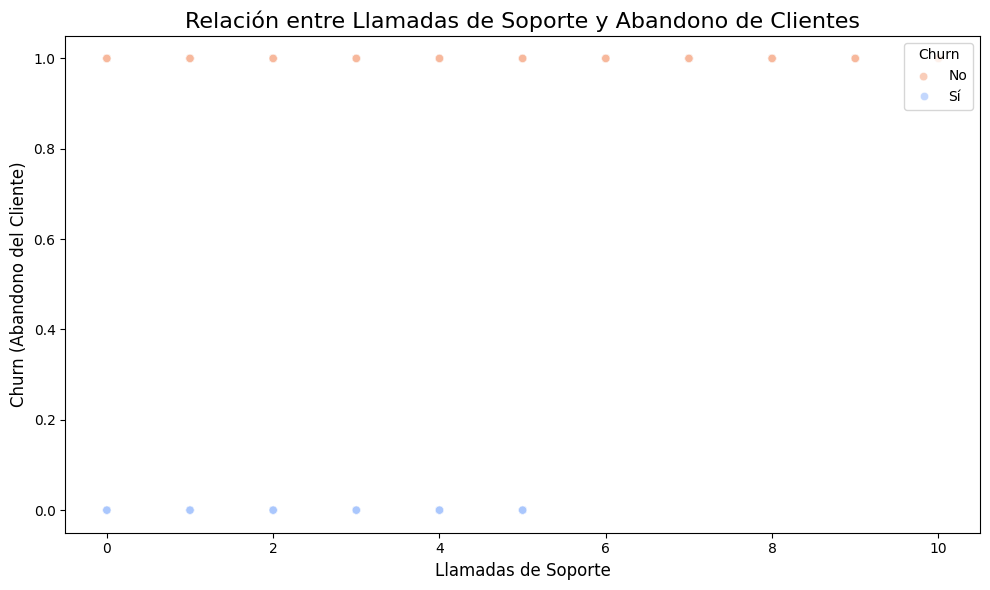

In [28]:
# Crear un gráfico de dispersión entre 'Support Calls' y 'Churn'
plt.figure(figsize=(10, 6))

# Usamos seaborn para crear un scatterplot con 'Churn' como color
sns.scatterplot(x='Support Calls', y='Churn', data=df, hue='Churn', palette='coolwarm', alpha=0.7)

# Agregar título y etiquetas
plt.title('Relación entre Llamadas de Soporte y Abandono de Clientes', fontsize=16)
plt.xlabel('Llamadas de Soporte', fontsize=12)
plt.ylabel('Churn (Abandono del Cliente)', fontsize=12)

# Mostrar la leyenda
plt.legend(title='Churn', labels=['No', 'Sí'], loc='upper right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


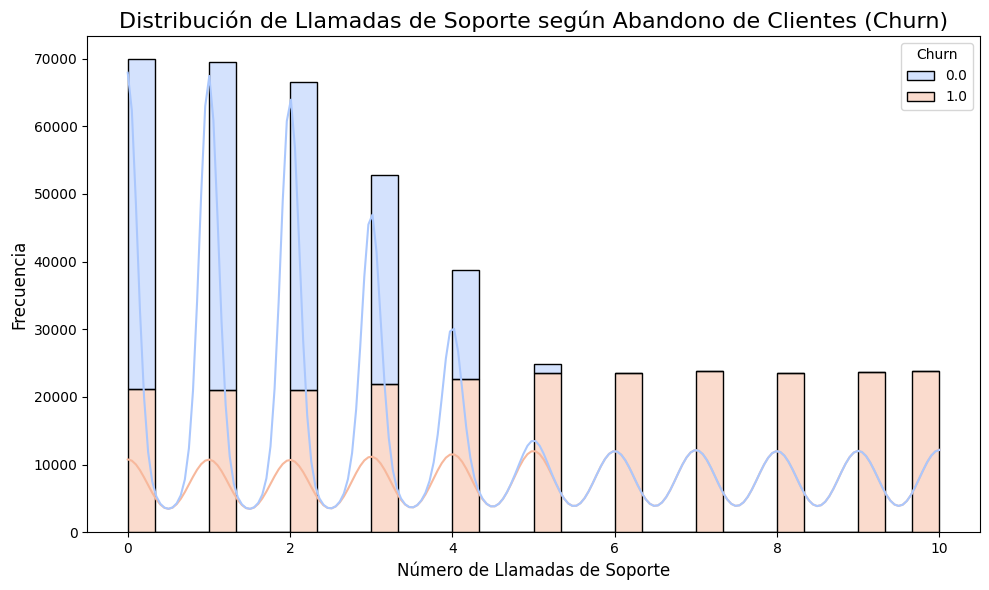

In [29]:
# Establecer el tamaño de la figura
plt.figure(figsize=(10, 6))

# Usar seaborn para crear un histograma con separación por 'Churn'
sns.histplot(data=df, x='Support Calls', hue='Churn', kde=True, bins=30, palette='coolwarm', multiple="stack")

# Agregar título y etiquetas
plt.title('Distribución de Llamadas de Soporte según Abandono de Clientes (Churn)', fontsize=16)
plt.xlabel('Número de Llamadas de Soporte', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


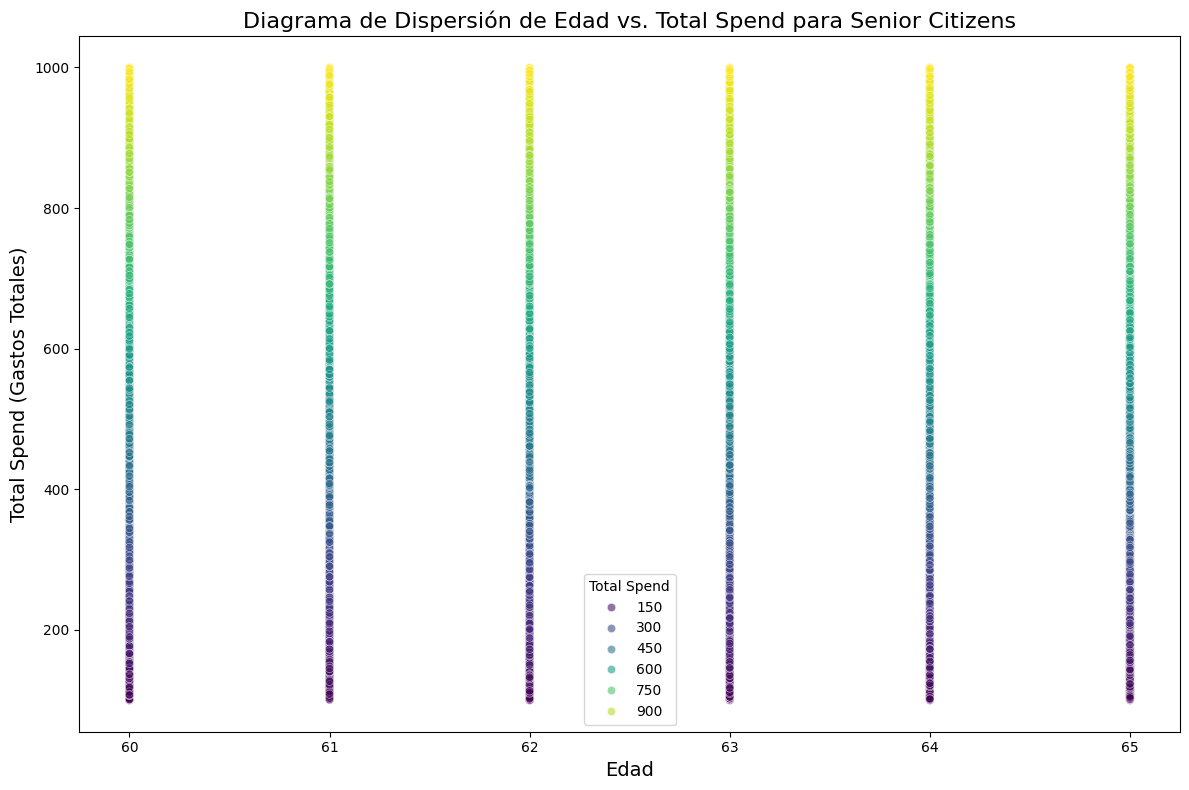

In [30]:

# Filtrar los datos para incluir solo a los Senior Citizens (mayores de 60 años)
df_senior = df[df['Age'] >= 60]

# Crear un diagrama de dispersión (scatter plot) entre 'Age' y 'Total Spend'
plt.figure(figsize=(12, 8))

# Usar seaborn para crear el diagrama de dispersión con una regresión lineal (opcional)
sns.scatterplot(data=df_senior, x='Age', y='Total Spend', hue='Total Spend', palette='viridis', alpha=0.6)

# Agregar título y etiquetas a los ejes
plt.title('Diagrama de Dispersión de Edad vs. Total Spend para Senior Citizens', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Total Spend (Gastos Totales)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


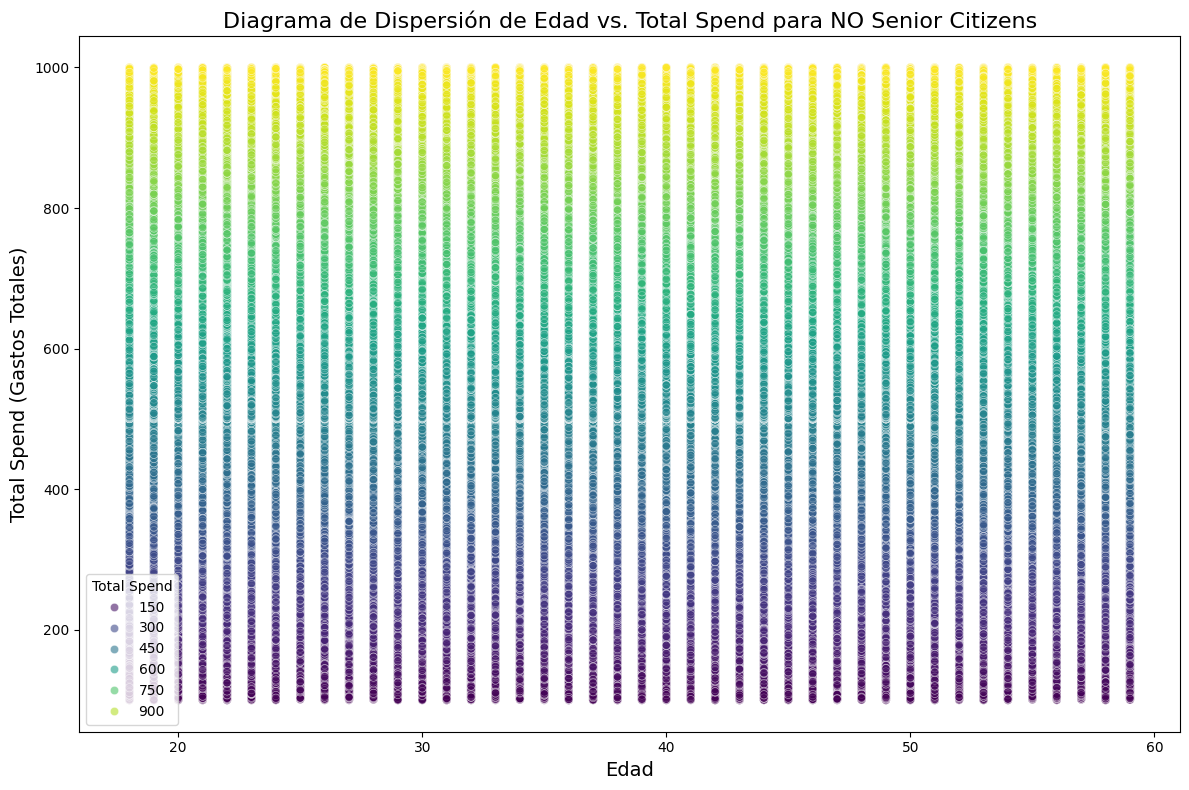

In [31]:
# Filtrar los datos para excluir solo a los Senior Citizens (mayores de 60 años)
df_senior = df[df['Age'] < 60]

# Crear un diagrama de dispersión (scatter plot) entre 'Age' y 'Total Spend'
plt.figure(figsize=(12, 8))

# Usar seaborn para crear el diagrama de dispersión con una regresión lineal (opcional)
sns.scatterplot(data=df_senior, x='Age', y='Total Spend', hue='Total Spend', palette='viridis', alpha=0.6)

# Agregar título y etiquetas a los ejes
plt.title('Diagrama de Dispersión de Edad vs. Total Spend para NO Senior Citizens', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Total Spend (Gastos Totales)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

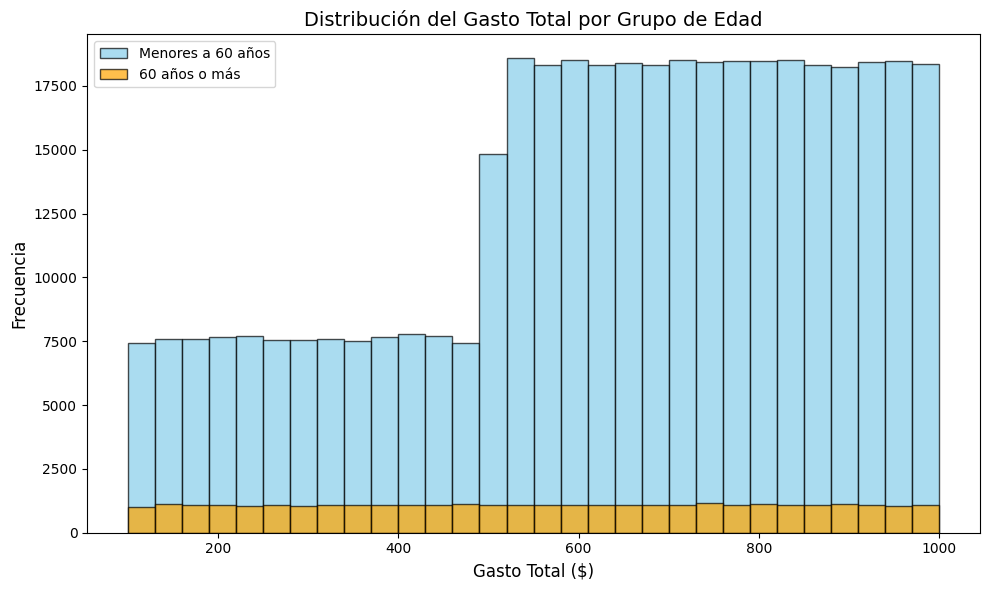

In [32]:
# Dividir los clientes en dos grupos: menores a 60 y 60 o más años
grupo_menor_60 = df[df['Age'] < 60]
grupo_60_o_mas = df[df['Age'] >= 60]

# Calcular el gasto total en cada grupo
gasto_menor_60 = grupo_menor_60['Total Spend']
gasto_60_o_mas = grupo_60_o_mas['Total Spend']

# Crear un histograma para cada grupo de edad
plt.figure(figsize=(10, 6))
plt.hist(gasto_menor_60, bins=30, alpha=0.7, label="Menores a 60 años", color='skyblue', edgecolor='black')
plt.hist(gasto_60_o_mas, bins=30, alpha=0.7, label="60 años o más", color='orange', edgecolor='black')

# Etiquetas y título
plt.title('Distribución del Gasto Total por Grupo de Edad', fontsize=14)
plt.xlabel('Gasto Total ($)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()

# Mostrar el histograma
plt.tight_layout()
plt.show()


**2 Estadísticas descriptivas**

In [33]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,440832.0,39.373153,12.442369,18.0,29.0,39.0,48.0,65.0
Tenure,440832.0,31.256336,17.255727,1.0,16.0,32.0,46.0,60.0
Usage Frequency,440832.0,15.807494,8.586242,1.0,9.0,16.0,23.0,30.0
Support Calls,440832.0,3.604437,3.070218,0.0,1.0,3.0,6.0,10.0
Payment Delay,440832.0,12.965722,8.258063,0.0,6.0,12.0,19.0,30.0
Total Spend,440832.0,631.616223,240.803001,100.0,480.0,661.0,830.0,1000.0
Last Interaction,440832.0,14.480868,8.596208,1.0,7.0,14.0,22.0,30.0
Churn,440832.0,0.567107,0.495477,0.0,0.0,1.0,1.0,1.0


Despues de aplicar todos los cambios al dataset veo una distro cuasi normal debido a algunos outliers.

Lo que me ha llamado la atención son mujeres con niveles altos de glucosa, BMI, SkinThickness y DiabetesPedigreeFunction SIN DIABETES.



<Axes: >

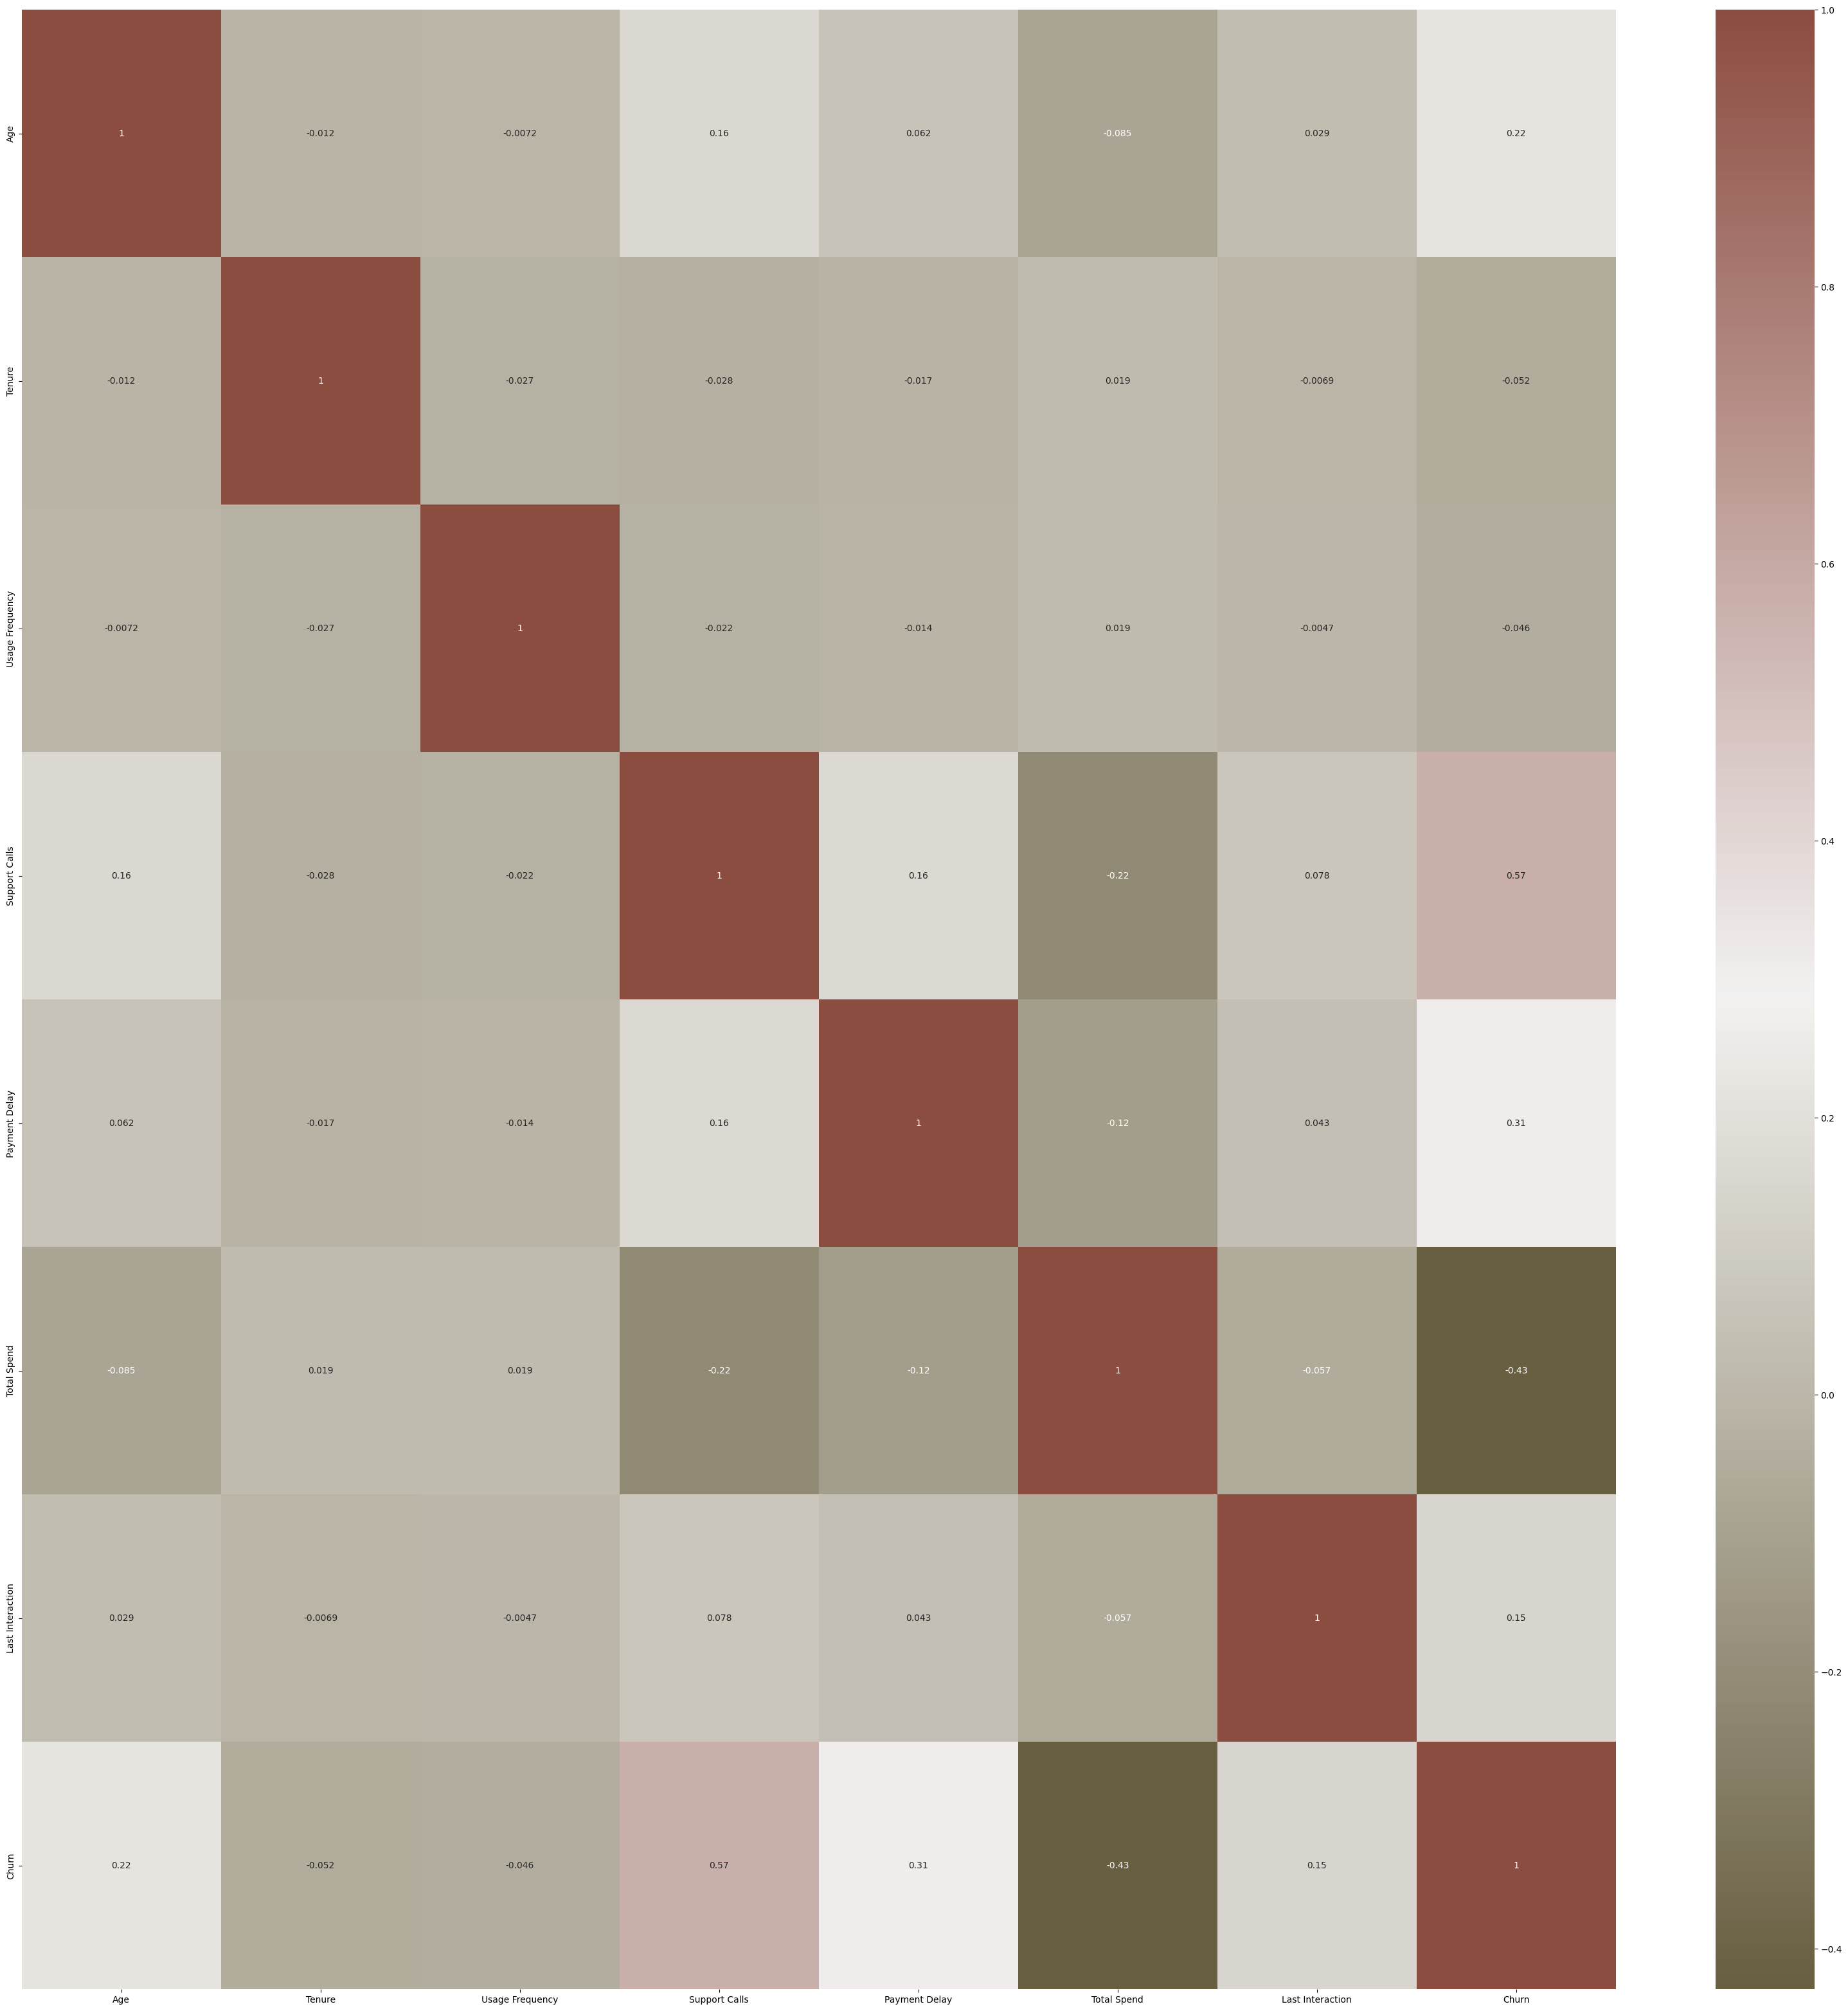

In [34]:
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= df.select_dtypes(include = 'number').corr()
f, ax = plt.subplots(figsize=(40,40))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [35]:
df.select_dtypes(include = 'number').corr()['Churn'].sort_values()

Total Spend        -0.429355
Tenure             -0.051919
Usage Frequency    -0.046101
Last Interaction    0.149616
Age                 0.218394
Payment Delay       0.312129
Support Calls       0.574267
Churn               1.000000
Name: Churn, dtype: float64

Se nota que el Costo tiene una relación casi fuerte. Tal vez pueda relacionarse con la mora.
La satisfacción del servicio tiene una relación fuerte. Hay que ver cuales son los problemas más frecuentes.
NO veo relacion de edad para salirse, por lo que va mas por la satisfacción del cliente en el servicio.

# FIN de Exploración de Datos

# 3. Implementación de Modelos:

## Paso 1: Cargar y preprocesar el archivo de entrenamiento y de test

In [50]:
# Cargar los datos de entrenamiento
path_train = '../../data/customer_churn_dataset-training-master.csv'
df_train = pd.read_csv(filepath_or_buffer=path_train, sep= ',', header=0)

# Cargar los datos de prueba
path_test = '../../data/customer_churn_dataset-testing-master.csv'
df_test = pd.read_csv(filepath_or_buffer=path_test, sep= ',', header=0)

# Preprocesamiento similar al realizado en los datos de entrenamiento
def preprocess_data(df):
    df.drop(['CustomerID'], axis=1, inplace=True)  # Eliminar la columna CustomerID
    df.drop(['Gender'], axis=1, inplace=True)  # Eliminar la columna CustomerID
    df.dropna(inplace=True)  # Eliminar filas con valores nulos
    
    # Identificar las columnas con valores 'Yes' y 'No'
    yes_no_columns = [col for col in df.columns if sorted(df[col].dropna().unique()) == ['No', 'Yes']]
    df[yes_no_columns] = df[yes_no_columns].apply(lambda col: col.map({'Yes': 1, 'No': 0}))

    # Cambiar los tipos de datos según un diccionario predefinido
    data_dict = {
        'Age': 'float64',
        'Tenure': 'float64',
        'Usage Frequency': 'float64',
        'Support Calls': 'float64',
        'Payment Delay': 'float64',
        'Subscription Type': 'category',
        'Contract Length': 'category',
        'Total Spend': 'float64',
        'Last Interaction': 'float64',
        'Churn': 'float64'
    }
    
    for column, dtype in data_dict.items():
        df[column] = df[column].astype(dtype, errors='ignore')
    
    # Eliminar duplicados
    df = df.drop_duplicates()
    
    return df

# Aplicar preprocesamiento a ambos datasets
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

# Verificar la forma y tipo de los datos preprocesados
print(f"Datos de entrenamiento: {df_train.info()}")
print(f"Datos de prueba: {df_test.info()}")


<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Age                440832 non-null  float64 
 1   Tenure             440832 non-null  float64 
 2   Usage Frequency    440832 non-null  float64 
 3   Support Calls      440832 non-null  float64 
 4   Payment Delay      440832 non-null  float64 
 5   Subscription Type  440832 non-null  category
 6   Contract Length    440832 non-null  category
 7   Total Spend        440832 non-null  float64 
 8   Last Interaction   440832 non-null  float64 
 9   Churn              440832 non-null  float64 
dtypes: category(2), float64(8)
memory usage: 31.1 MB
Datos de entrenamiento: None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0  

## Paso 2: Separar las características y etiquetas (en ambos datasets)
Después de hacer el preprocesamiento en ambos conjuntos, vamos a separar las características (X) de las etiquetas (y) en ambos datasets.

In [51]:
# Separar características y etiqueta para entrenamiento
X_train = df_train.drop('Churn', axis=1)  # Características del dataset de entrenamiento
y_train = df_train['Churn']  # Etiqueta (Churn) del dataset de entrenamiento

# Separar características y etiqueta para prueba
X_test = df_test.drop('Churn', axis=1)  # Características del dataset de prueba
y_test = df_test['Churn']  # Etiqueta (Churn) del dataset de prueba

# Verificar las formas de las variables
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")


Forma de X_train: (440832, 9)
Forma de X_test: (64374, 9)
Forma de y_train: (440832,)
Forma de y_test: (64374,)


In [58]:
cat_columnas_nominal = ['Subscription Type','Contract Length']
#df.select_dtypes(exclude = 'object').columns.to_list()
columns_numericas = ['Age',
'Tenure',
'Usage Frequency',
'Support Calls',
'Payment Delay',
'Total Spend',
'Last Interaction']

In [59]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Age                440832 non-null  float64 
 1   Tenure             440832 non-null  float64 
 2   Usage Frequency    440832 non-null  float64 
 3   Support Calls      440832 non-null  float64 
 4   Payment Delay      440832 non-null  float64 
 5   Subscription Type  440832 non-null  category
 6   Contract Length    440832 non-null  category
 7   Total Spend        440832 non-null  float64 
 8   Last Interaction   440832 non-null  float64 
 9   Churn              440832 non-null  float64 
dtypes: category(2), float64(8)
memory usage: 31.1 MB


In [60]:
df_tratado = df_train.copy()

*Pipeline*

In [61]:
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer

In [62]:
# Transformadores nominal
one_hot_encoder = OneHotEncoder()

#ordinal_encoder = OrdinalEncoder()

standard_scaler = StandardScaler()

imputer_categoricas = SimpleImputer(strategy='most_frequent')

imputer_num = SimpleImputer(strategy='mean')

In [63]:
col_transformer = make_column_transformer(
    (make_pipeline(imputer_categoricas, one_hot_encoder), cat_columnas_nominal),
    (make_pipeline(imputer_num, standard_scaler), columns_numericas),
    remainder='passthrough'
)

In [64]:
col_transformer.fit(df_tratado)

c:\Users\edgar\miniforge3\envs\machine_learning_ds02\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['Subscription Type', 'Contract Length']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'Tenure', 'Usage Frequency',
                                  'Support Calls', 'Payment Delay',
                                  'Total Spend', 'Last Interaction'])])

In [65]:
aux = col_transformer.transform(df_tratado)
df_procesado = pd.DataFrame(aux,columns=col_transformer.get_feature_names_out())
df_procesado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440832 entries, 0 to 440831
Data columns (total 14 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   pipeline-1__Subscription Type_Basic     440832 non-null  float64
 1   pipeline-1__Subscription Type_Premium   440832 non-null  float64
 2   pipeline-1__Subscription Type_Standard  440832 non-null  float64
 3   pipeline-1__Contract Length_Annual      440832 non-null  float64
 4   pipeline-1__Contract Length_Monthly     440832 non-null  float64
 5   pipeline-1__Contract Length_Quarterly   440832 non-null  float64
 6   pipeline-2__Age                         440832 non-null  float64
 7   pipeline-2__Tenure                      440832 non-null  float64
 8   pipeline-2__Usage Frequency             440832 non-null  float64
 9   pipeline-2__Support Calls               440832 non-null  float64
 10  pipeline-2__Payment Delay               4408

In [66]:
df_procesado.columns = df_procesado.columns.str.split('__').str[-1]
df_procesado.columns.to_list()

['Subscription Type_Basic',
 'Subscription Type_Premium',
 'Subscription Type_Standard',
 'Contract Length_Annual',
 'Contract Length_Monthly',
 'Contract Length_Quarterly',
 'Age',
 'Tenure',
 'Usage Frequency',
 'Support Calls',
 'Payment Delay',
 'Total Spend',
 'Last Interaction',
 'Churn']

In [67]:
df_procesado

,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
0,0.0,0.0,1.0,1.0,0.0,0.0,-0.753326,0.448760,-0.210511,0.454549,0.609620,1.247427,0.293052,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,2.059646,1.028278,-1.724562,2.083100,-0.601319,-0.309865,-0.986584,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.255940,-1.000036,-1.375166,0.780259,0.609620,-1.854698,-1.335575,1.0
3,0.0,0.0,1.0,0.0,1.0,0.0,1.497051,0.390808,0.604748,1.105969,-0.722413,-0.978462,1.689018,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,-1.315921,0.043097,0.488282,0.454549,-0.601319,-0.060698,0.642043,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440827,0.0,1.0,0.0,1.0,0.0,0.0,0.211121,1.318037,-0.094045,-0.848291,-1.206788,0.352005,-0.753923,0.0
440828,0.0,1.0,0.0,1.0,0.0,0.0,-1.155179,-1.347747,-0.326976,-0.848291,0.851808,0.472436,-1.451906,0.0
440829,0.0,0.0,1.0,0.0,0.0,1.0,-1.074809,0.216952,1.303541,-0.848291,-0.964600,1.435589,-0.637592,0.0
440830,0.0,0.0,1.0,0.0,0.0,1.0,-0.914068,1.375989,-0.210511,-0.522581,-1.570070,-0.120706,-1.451906,0.0


**`3.2. División de Muestra Train y Test`**

El objetivo de esta fase es poder divir en dos partes: el conjunto de entrenamiento (train) y el conjunto de prueba (test). Estas divisiones se utilizan para entrenar y evaluar los modelos.

- `|Train:|` El conjunto de entrenamiento se utiliza para entrenar el modelo de aprendizaje automático. Es aquí donde el modelo "aprende" los patrones y relaciones en los datos para poder hacer predicciones o clasificaciones.

- `|Test:|` El conjunto de prueba se utiliza para evaluar el rendimiento del modelo en datos no vistos durante el entrenamiento. Es una medida objetiva de la capacidad del modelo para generalizar y realizar predicciones precisas en nuevos datos.

In [68]:
X = df_procesado.drop(columns=['Churn'])
y = df_procesado['Churn']

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify= y)

In [71]:
print(f"Tamaño del total de datos: {len(df_procesado)}")
print(f"Tamaño de train: {len(X_train)}")
print(f"Tamaño de test: {len(X_test)}")

Tamaño del total de datos: 440832
Tamaño de train: 352665
Tamaño de test: 88167


>**Observación**
>- Se puede observar que el dataset se ha dividido en 2 partes, en `train` y `test`

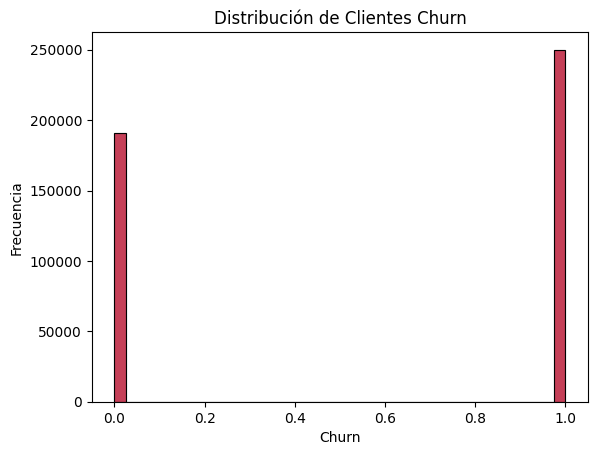

In [73]:
sns.histplot((df_procesado['Churn']),color = '#B20020')
plt.title("Distribución de Clientes Churn", fontsize=12)  
plt.xlabel("Churn", fontsize=10)  
plt.ylabel("Frecuencia", fontsize=10) 
plt.show()

>**Observaciones**
>- Se puede observar que para nuestro target se tienen 2 valores sea 1 o 0, es decir binarios donde se cuenta mas valores en 1, en pocas palabras esta un poco desbalanceada

In [74]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [75]:
from collections import Counter

print('Distribución original de clases:', Counter(y_train))
print('Distribución de clases después de SMOTE:', Counter(y_train_balanced))

Distribución original de clases: Counter({1.0: 199999, 0.0: 152666})
Distribución de clases después de SMOTE: Counter({0.0: 199999, 1.0: 199999})


>**Observaciones**
>- Es decir, el conjunto de datos estaba desbalanceado, con más ejemplos de la clase 1 que de la clase 0.
>- Ahora tanto la clase 1.0 como la clase 0.0 tienen 199999 ejemplos cada una.

**`3.4. Modelo de Clasificación`**
En este caso debemos de utilizar dos modelos que es RandomForestClassifier y XGBoost para luego evaluar sus meétricas de desempeño.

*Modelo RandomForestClassifier*

In [76]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(random_state=42)

### Limite el espacio, porque demora mucho y ya me desespera el tiempo de espera.

In [91]:
# Importamos las librerías necesarias
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Paso 1: Crear una muestra aleatoria de tus datos con reemplazo
# Tomamos una muestra aleatoria de los datos (muestra con reemplazo) para acelerar el entrenamiento

# Suponiendo que tienes X_train y y_train ya definidos
X_train_resampled, y_train_resampled = resample(X_train_balanced, y_train_balanced, 
                                               n_samples=150000,   # Número de muestras a seleccionar (puedes ajustar este número)
                                               random_state=42)   # Para que sea reproducible

# Paso 2: Crear el modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Paso 3: Definir los "trucos" (parámetros) que queremos optimizar
param_dist = {
    'n_estimators': randint(50, 200),       # Número de árboles (de 50 a 200)
    'max_depth': randint(3, 15),             # Profundidad del árbol (de 3 a 15 niveles)
    'min_samples_split': randint(2, 20),     # Mínimo número de muestras para dividir un árbol
    'min_samples_leaf': randint(1, 20),      # Mínimo número de muestras para ser hoja
    'bootstrap': [True, False],              # Si el árbol debe "reemplazar" datos al elegirlos
}

# Paso 4: Usar RandomizedSearchCV para encontrar los mejores parámetros
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=10,  # Número de combinaciones a probar
                                   cv=3,       # Número de divisiones para la validación cruzada
                                   scoring='accuracy',  # Queremos maximizar la precisión
                                   random_state=42,     # Para que sea reproducible
                                   n_jobs=-1)           # Usar todos los núcleos de la computadora

# Paso 5: Ajustar el modelo con la muestra aleatoria
random_search.fit(X_train_resampled, y_train_resampled)

# Paso 6: Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", random_search.best_params_)

# Paso 7: Usar el mejor modelo encontrado
best_rf = random_search.best_estimator_

# Paso 8: Evaluar el modelo en los datos de entrenamiento (o prueba)
accuracy = best_rf.score(X_train_resampled, y_train_resampled)
print("Precisión del mejor modelo con la muestra aleatoria:", accuracy)


Mejores parámetros encontrados: {'bootstrap': False, 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 107}
Precisión del mejor modelo con la muestra aleatoria: 0.9912


In [92]:
# Paso 2: Realizar predicciones en el conjunto de test (o en otro conjunto de datos de tu elección)
# Si tienes un conjunto de datos de prueba (X_test, y_test)
y_pred_rf = best_rf.predict(X_test)

# Paso 3: Evaluar las predicciones usando métricas como precisión, recall, f1-score, etc.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluar precisión
accuracy = accuracy_score(y_test, y_pred_rf)
print("Precisión:", accuracy)

# Evaluar precisión (precision)
precision = precision_score(y_test, y_pred_rf)
print("Precisión (Precision):", precision)

# Evaluar recall
recall = recall_score(y_test, y_pred_rf)
print("Recall:", recall)

# Evaluar f1-score
f1 = f1_score(y_test, y_pred_rf)
print("F1-score:", f1)

# Evaluar ROC-AUC (si es un problema binario)
roc_auc = roc_auc_score(y_test, y_pred_rf)
print("ROC-AUC:", roc_auc)

# Paso 4: Mostrar algunas predicciones
print("Primeras 10 predicciones:", y_pred_rf[:10])

Precisión: 0.9875236766590675
Precisión (Precision): 0.9999386578333946
Recall: 0.97806
F1-score: 0.9888783289183669
ROC-AUC: 0.9889906990331964
Primeras 10 predicciones: [1. 0. 1. 0. 0. 1. 0. 0. 1. 1.]


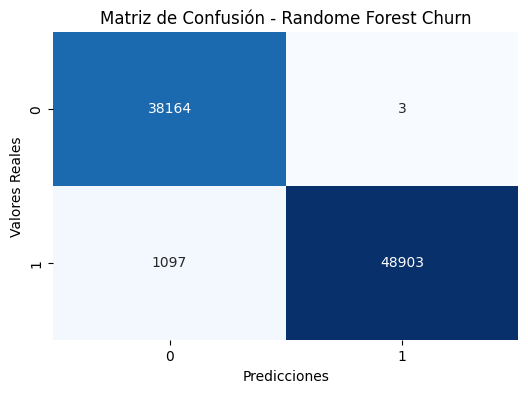

Evaluación de Random Forest Churn:
Accuracy: 0.9875236766590675
Precision: 0.9999386578333946
Recall: 0.97806
F1-score: 0.9888783289183669
Matriz de Confusión:
 [[38164     3]
 [ 1097 48903]]


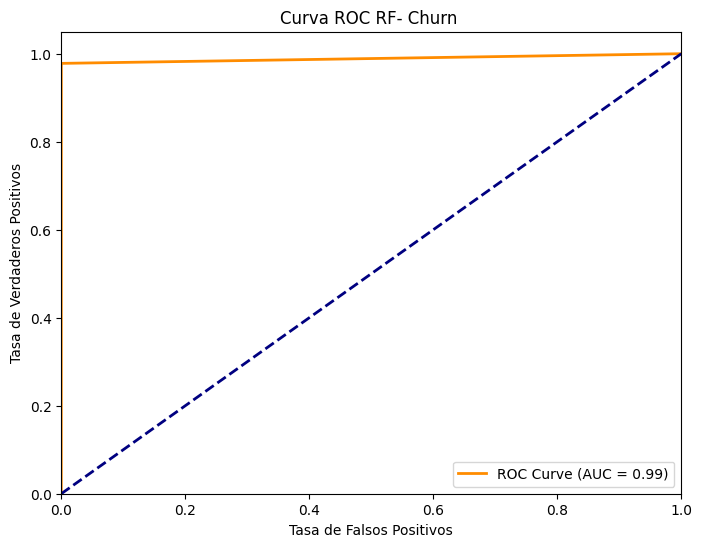

In [93]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Función para graficar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.show()

# Graficar la matriz de confusión para Randome Forest
plot_confusion_matrix(y_test, y_pred_rf, "Randome Forest Churn")
print("Evaluación de Random Forest Churn:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_rf))
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc, "Curva ROC RF- Churn ")

## XGBoost

In [97]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Limitar el número de registros a 150,000 (solo para entrenamiento)
X_train_balanced_limited = X_train_balanced.sample(n=150000, random_state=42)
y_train_balanced_limited = y_train_balanced.loc[X_train_balanced_limited.index]

# Creando el modelo XGBoost con los parámetros establecidos
model = xgb.XGBClassifier(
    use_label_encoder=False,
    learning_rate=0.15,   # Tasa de aprendizaje
    n_estimators=150,     # El número de árboles
    max_depth=10,         # Profundidad máxima de los árboles
    min_child_weight=10,  # Número mínimo de muestras por hoja (en XGBoost es 'min_child_weight', no 'min_samples_leaf')
    subsample=0.8,        # Frecuencia de submuestreo
    colsample_bytree=0.7, # Frecuencia de muestreo de características
    n_iter_no_change=20,  # Parada temprana después de 20 iteraciones sin mejora
    random_state=42
)

# Entrenando el modelo con el conjunto limitado de 150,000 registros
model.fit(X_train_balanced_limited, y_train_balanced_limited)

# Haciendo predicciones con el modelo entrenado
y_pred_xgboost = model.predict(X_test)

# Evaluando el modelo
accuracy = accuracy_score(y_test, y_pred_xgboost)
print(f'Accuracy: {accuracy:.4f}')

# Imprimiendo el reporte de clasificación
print(classification_report(y_test, y_pred_xgboost))

# Evaluando el ROC-AUC
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f'ROC-AUC: {roc_auc:.4f}')


c:\Users\edgar\miniforge3\envs\machine_learning_ds02\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:13:26] WARNING: D:\bld\xgboost-split_1730232592996\work\src\learner.cc:740: 
Parameters: { "n_iter_no_change", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9909
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     38167
         1.0       1.00      0.98      0.99     50000

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167

ROC-AUC: 0.9974


# Codigo para Optimizar XGBoost

In [98]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250],          # Número de árboles
    'max_depth': [3, 6, 10, 12, 15],                    # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],     # Tasa de aprendizaje
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],             # Fracción de muestras utilizadas para cada árbol
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],     # Fracción de características para cada árbol
    'min_child_weight': [1, 5, 10, 20],                 # Número mínimo de muestras en cada hoja
    'gamma': [0, 0.1, 0.2, 0.3],                       # Regularización de complejidad de árbol
    'scale_pos_weight': [1, 5, 10],                     # Peso para las clases positivas (útil para datos desbalanceados)
}

# Crear el modelo XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,                     # El modelo que vamos a optimizar
    param_distributions=param_dist,       # El espacio de búsqueda
    n_iter=10,                            # Número de combinaciones aleatorias a probar
    scoring='accuracy',                  # Métrica a optimizar (en este caso accuracy)
    cv=3,                                 # Número de folds para cross-validation
    verbose=3,                            # Muestra los resultados de cada prueba
    random_state=42,                     # Semilla para reproducibilidad
    n_jobs=-1                             # Usar todos los núcleos del procesador para acelerar el proceso
)

# Realizar la búsqueda aleatoria
random_search.fit(X_train_balanced_limited, y_train_balanced_limited)

# Mostrar los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: {random_search.best_params_}")

# Obtener el mejor modelo entrenado
best_model = random_search.best_estimator_

# Haciendo predicciones con el mejor modelo
y_pred_xgboost_optimized = best_model.predict(X_test)

# Evaluando el modelo optimizado
accuracy = accuracy_score(y_test, y_pred_xgboost_optimized)
print(f'Accuracy (Optimizado): {accuracy:.4f}')

# Imprimiendo el reporte de clasificación
print(classification_report(y_test, y_pred_xgboost_optimized))

# Evaluando el ROC-AUC
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f'ROC-AUC (Optimizado): {roc_auc:.4f}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\edgar\miniforge3\envs\machine_learning_ds02\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:44] WARNING: D:\bld\xgboost-split_1730232592996\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros encontrados: {'subsample': 0.9, 'scale_pos_weight': 1, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.8}
Accuracy (Optimizado): 0.9911
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     38167
         1.0       1.00      0.98      0.99     50000

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167

ROC-AUC (Optimizado): 0.9973


In [100]:
# Usar el mejor modelo encontrado por RandomizedSearchCV
best_model = random_search.best_estimator_

# Hacer predicciones con el conjunto de test utilizando el modelo optimizado
y_pred_xgboost_optimized = best_model.predict(X_test)
y_proba_xgboost = best_model.predict_proba(X_test)[:, 1]

# Evaluando el modelo optimizado

# Calculamos la exactitud del modelo
accuracy = accuracy_score(y_test, y_pred_xgboost_optimized)
print(f'Accuracy (Optimizado): {accuracy:.4f}')

# Imprimir el reporte de clasificación (precision, recall, f1-score, etc.)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_xgboost_optimized))

# Calcular el ROC-AUC para evaluar la capacidad del modelo de clasificar correctamente las clases
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f'ROC-AUC (Optimizado): {roc_auc:.4f}')


Accuracy (Optimizado): 0.9911
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     38167
         1.0       1.00      0.98      0.99     50000

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167

ROC-AUC (Optimizado): 0.9973



Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     38167
         1.0       1.00      0.98      0.99     50000

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167

ROC-AUC: 0.9973


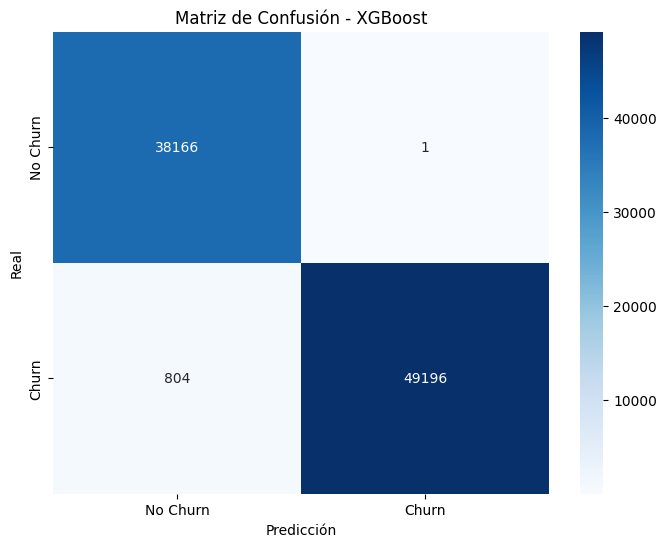

In [102]:
# Métricas de evaluación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_xgboost_optimized))

roc_auc = roc_auc_score(y_test, y_proba_xgboost)
print(f"ROC-AUC: {roc_auc:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_xgboost)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Comparaciones de los Modelos.


| Modelo/MC         | Falso Positivo | Falso Negativo | Verdadero Positivo | Verdadero Negativo |
|-------------------|----------------|----------------|--------------------|--------------------|
| Random Forest Optimizado    | 3              | 1097           | 48903              | 38164              |
| XGBoost Optimizado | 1              | 804            | 49196              | 38166              |



# El XGBoost Optimizado es mejor clasificador Binario.